Define const.

In [1]:
m_e = 9.1093837e-28 #mass of electron
c = 29979245800.0 #speed of light
sigma_T = 6.652448e-25 #Thomson cross sectio
ev_to_erg = 1.60217662e-12 #change unit from ev to erg

Import packages

In [2]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt 

Functions to realize equation in our paper

In [3]:
#Caculate angle of collision.In the approximate case, it degenerates into the equation (4) as presented in our paper.
def theta(R,theta_M,theta_G,phi):
    dx_M = R_M*np.sin(theta_M)
    dx_G = R_G*np.sin(theta_G)
    dx = np.sqrt(dx_M**2+dx_G**2-2.*dx_M*dx_G*np.cos(phi))
    dy = R_G*np.cos(theta_G)-R_M*np.cos(theta_M)+R-R_G
    thetam = np.arctan(dx/dy)
    if thetam > 0.01:
        return 0.01
    else:
        return thetam

#Caculate max of radius(eqution (5))
def R_max(theta_G):
    if(1-2*c*T_90/((1+z)*theta_G**2*R_G)>0):
        return R_G/(1-2*c*T_90/((1+z)*theta_G**2*R_G))
    else:
        return(R_G*1e3)

#Define function that get L_M, E_P, alpha, beta from light curve
def L_M(theta_G,R):
    t_R = 226+(1+z)*T_G - (1+z)*theta_G**2*R_G/2/c*(R_G/R)
    if t_R < t[0] or t_R > t[-1]:
        return 0,1,3,1
    else:
        for index in range(len(t)):
            if t_R < t[index]:
                break
    return L[index],alphaM[index],betaM[index],EP[index]

#Define number density of band function(equation(6),(7)and(8))
def n_Mev(theta_G,R,E_Ma):
    L_MR,alpha_M,beta_M,E_P = L_M(theta_G,R)
    n_Mev0 = L_MR/((1+z)*E_P**2*(1/(2-alpha_M)+1/(beta_M-2)*(1-E_P**(beta_M-2)*E_maxo**(2-beta_M)))*4.*np.pi*R**2*c)#(equation(7)and(8))
    result = np.array([])
    for E_M in E_Ma:
        if E_M<E_P:
            result = np.append(result,n_Mev0*(E_M/E_P)**(-alpha_M))
        elif E_M<E_max:
            result = np.append(result,n_Mev0*(E_M/E_P)**(-beta_M))
        else:
            result = np.append(result,0)
    return result

#Caculate E_{M,min}(equation(9))
def E_Mmin(theta):
    return 2*(m_e*c**2)**2/(1+z)**2/(1-np.cos(theta))/E_G

# Caculate beta hat(equation(11))
def beta(E_M,theta):
    return np.sqrt(np.abs(1-2.0*(m_e*c**2/(1+z))**2/E_M/E_G/(1-np.cos(theta))))

# caculate cross-section(equation(10))
def sigma(beta):
    return 3./16.*sigma_T*(1.-beta**2)*((3.-beta**4)*np.log((1.+beta)/(1.-beta))-2.*beta*(2.-beta**2))

Integration functions(equation(12)and(13))

In [4]:
#Caculate  optical depth as function of energy and angle of TeV photons \tau(\theta_T,E_T) (equation(12))
#integrand
def y0(theta_G,E_M,phi,theta_M,R):
    theta0 = theta(R,theta_M,theta_G,phi)
    beta0 = beta(E_M,theta0)
    sigma0 = sigma(beta0)
    n_Mev0 = n_Mev(theta_G,R,E_M)
    return n_Mev0*sigma0*(1-np.cos(theta0))

#Integration over energy
def iyx0(theta_G,x1,x2,x3):
    theta0 = theta(x3,x2,theta_G,0)
    E_Mmin0 = E_Mmin(theta0)
    if E_Mmin0 > E_max:
        return 0
    x0 = np.logspace(np.log(E_Mmin0)/np.log(10),np.log(E_max)/np.log(10),101)
    y = y0(theta_G,x0,x1,x2,x3)
    return integrate.simpson(y,x0)

def iyx2(theta_G,x3):
    x2 = np.linspace(0,0.01,10)
    iyx2 = np.array([])
    for x in x2:
        iyx2=np.append(iyx2,iyx0(theta_G,0,x2,x3))
    return integrate.simpson(iyx2,x2)

#Integration over radius
def iyx3(theta_G,x3min,x3max):
    x3 = np.logspace(np.log(x3min)/np.log(10),np.log(x3max)/np.log(10),51)
    iyx3 = np.array([])
    for x in x3:
        iyx3=np.append(iyx3,iyx0(theta_G,0,0.01,x))
    return integrate.simpson(iyx3,x3)

#integration over angle to caculate  optical depth (equation (13))
def yy(theta_Gmax):
    theta_Ga = np.logspace(-4,np.log(theta_Gmax)/np.log(10),30)
    iyym = np.array([])
    iyyd = np.array([])
    for theta_Gx in theta_Ga:
        D = 1/(Gamma_G*(1-beta_Gb*np.cos(theta_Gx)))
        tua = iyx3(theta_Gx,R_G,R_max(theta_Gx))
        iyym = np.append(iyym,D**(3+beta_G)*np.exp(-tua)*theta_Gx)
        iyyd = np.append(iyyd,D**(3+beta_G)*theta_Gx)
    return integrate.simpson(iyym,theta_Ga)/integrate.simpson(iyyd,theta_Ga)

Import data

In [5]:
data = np.loadtxt('c.txt') #name of data file
t = data[:,0] #time
alphaM = data[:,1] #low energy photon index
betaM = data[:,2] #high energy photon index
EP = data[:,3]*1e3*ev_to_erg #peak energy
L = data[:,4]*4*np.pi*(2.23e27)**2 #luminosity
print(t,alphaM,betaM,EP,L)


[208.64  216.832 227.    228.    229.    230.    231.    232.    233.
 234.    241.408 249.6  ] [0.   1.33 0.78 0.75 0.76 0.76 0.76 0.72 0.63 0.77 0.86 1.25] [0.   2.4  2.14 2.1  2.16 2.37 2.08 2.28 2.29 2.5  2.18 2.75] [0.00000000e+00 1.57173526e-06 4.87542345e-06 2.03408338e-06
 1.83729924e-06 2.00505611e-06 2.43767968e-06 1.75596507e-06
 9.72157514e-07 1.34759476e-06 2.59071959e-06 1.71753334e-06] [0.00000000e+00 2.26843435e+51 8.06137827e+52 8.68629132e+53
 7.56144784e+53 6.15539349e+53 1.07485044e+54 8.74878262e+53
 7.93639566e+53 5.12428696e+53 1.35606131e+53 1.96847609e+52]


Caculate light depth

In [6]:
z = 0.151 #Redshift
E_G = 7e12*ev_to_erg #Energy of TeV photon
E_maxo = 10e6*ev_to_erg #Maxmium energy of observed MeV photon
E_max = 7e12*ev_to_erg #Maxmium energy of MeV photon
beta_G = 2.3 #photon index of TeV photons
T_90 =100 #T_90 (it does not matter because we hadly reach the R_max)
eta = 1 #Radiative efficiency (=1 in our case)
Gamma_G = 560 #Bulk Lorentz factor of TeV photons
R_M = 0 #Emitting radius of MeV photons
#Funtion to caculate light depth of every time
def tau_G(t_G):
    global R_G,beta_Gb,T_G
    T_G = t_G/(1+z)
    R_G = 2*Gamma_G*Gamma_G*c*T_G
    beta_Gb = np.sqrt(1-1/Gamma_G**2)
    tua_e = -np.log(yy(1/Gamma_G))
    return tua_e

Caculate light depth of every time

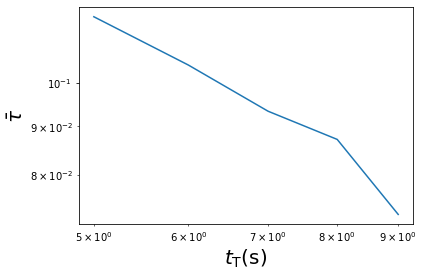

In [7]:
ta = np.arange(5,10,1)#Time period
taut = np.array([])#Optical depth
for tb in ta:
    taut = np.append(taut,tau_G(tb))
np.savetxt('ttt.txt',np.vstack((ta,taut)))#savetxt
plt.xlabel(r'$t_{\rm T}$(s)', fontsize=20)
plt.ylabel(r'$\bar{\tau}$', fontsize=20)
plt.loglog(ta,taut)#plot figure

Caculate minimal Lorentz factor

In [8]:
z = 0.151 #redshift
E_G = 7e12*ev_to_erg #Energy of TeV photon
E_maxo = 10e6*ev_to_erg #Maxmium energy of observed MeV photon
E_max = 7e12*ev_to_erg #Maxmium energy of MeV photon
beta_G = 2.3 #photon index of TeV photons
T_90 =100 #T_90 (it does not matter because we hadly reach the R_max)
eta = 1 #Radiative efficiency (=1 in our case)
R_M = 0 #Emitting radius of MeV photons
#Function to caculate minimal Lorentz factor of every time
def gamma_min(t_G):
    global Gamma_G,R_G,beta_Gb,T_G
    T_G = t_G/(1+z)
    Gamma_gmin = 0.1
    Gamma_gmax = 1000
    for i in range(30):
        Gamma_G =(Gamma_gmin+Gamma_gmax)/2.
        R_G = 2*Gamma_G*Gamma_G*c*T_G*eta
        beta_Gb = np.sqrt(1-1/Gamma_G**2)
        tua_e = -np.log(yy(1/Gamma_G))
        if np.abs(tua_e-1)<1e-3:
            return Gamma_G
            break
        elif tua_e>1:
            Gamma_gmin = Gamma_G
        else:
            Gamma_gmax = Gamma_G

Caculate minimal Lorentz factor of every time

4
5
6
7
8
9


Text(0, 0.5, '$\\Gamma_{\\rm T,min}$')

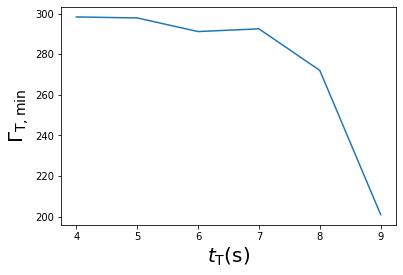

In [9]:
ta = np.arange(4,10,1) #Time period
gm = np.array([])#Minimal Lorentz factor
for tb in ta:
    print(tb)
    gm = np.append(gm,gamma_min(tb))
plt.plot(ta,gm)#plot figure
plt.xlabel(r'$t_{\rm T}$(s)', fontsize=20)
plt.ylabel(r'$\Gamma_{\rm T,min}$', fontsize=20)